<a href="https://colab.research.google.com/github/janani225/named-entity-recognition/blob/main/EX_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model


In [3]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [4]:
data.head(50)


data = data.fillna(method="ffill")


data.head(50)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 24910
Unique tags in corpus: 17


In [6]:
words=list(data['Word'].unique())
words.append("ENDPAD")
tags=list(data['Tag'].unique())

In [7]:
print("Unique tags are:", tags)

Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [8]:
num_words = len(words)
num_tags = len(tags)


num_words


24911

In [9]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [10]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [11]:
len(sentences)


sentences[0]


[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [12]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}


In [13]:
word2idx

{'Thousands': 1,
 'of': 2,
 'demonstrators': 3,
 'have': 4,
 'marched': 5,
 'through': 6,
 'London': 7,
 'to': 8,
 'protest': 9,
 'the': 10,
 'war': 11,
 'in': 12,
 'Iraq': 13,
 'and': 14,
 'demand': 15,
 'withdrawal': 16,
 'British': 17,
 'troops': 18,
 'from': 19,
 'that': 20,
 'country': 21,
 '.': 22,
 'Families': 23,
 'soldiers': 24,
 'killed': 25,
 'conflict': 26,
 'joined': 27,
 'protesters': 28,
 'who': 29,
 'carried': 30,
 'banners': 31,
 'with': 32,
 'such': 33,
 'slogans': 34,
 'as': 35,
 '"': 36,
 'Bush': 37,
 'Number': 38,
 'One': 39,
 'Terrorist': 40,
 'Stop': 41,
 'Bombings': 42,
 'They': 43,
 'Houses': 44,
 'Parliament': 45,
 'a': 46,
 'rally': 47,
 'Hyde': 48,
 'Park': 49,
 'Police': 50,
 'put': 51,
 'number': 52,
 'marchers': 53,
 'at': 54,
 '10,000': 55,
 'while': 56,
 'organizers': 57,
 'claimed': 58,
 'it': 59,
 'was': 60,
 '1,00,000': 61,
 'The': 62,
 'comes': 63,
 'on': 64,
 'eve': 65,
 'annual': 66,
 'conference': 67,
 'Britain': 68,
 "'s": 69,
 'ruling': 70,
 'L

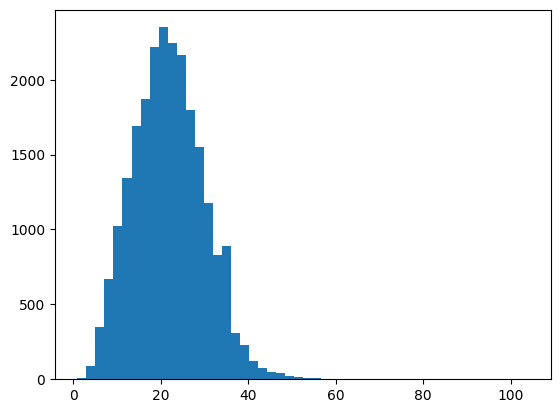

In [14]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [15]:
X1 = [[word2idx[w[0]] for w in s] for s in sentences]


type(X1[0])


X1[0]


max_len = 50

In [16]:
nums = [[1], [2, 3], [4, 5, 6]]
sequence.pad_sequences(nums)

array([[0, 0, 1],
       [0, 2, 3],
       [4, 5, 6]], dtype=int32)

In [17]:
nums = [[1], [2, 3], [4, 5, 6]]
sequence.pad_sequences(nums,maxlen=2)

array([[0, 1],
       [2, 3],
       [5, 6]], dtype=int32)

In [18]:
X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)


X[0]

array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    10,    16,     2,
          17,    18,    19,    20,    21,    22, 24910, 24910, 24910,
       24910, 24910, 24910, 24910, 24910, 24910, 24910, 24910, 24910,
       24910, 24910, 24910, 24910, 24910, 24910, 24910, 24910, 24910,
       24910, 24910, 24910, 24910, 24910], dtype=int32)

In [19]:
y1 = [[tag2idx[w[2]] for w in s] for s in sentences]


In [20]:
y = sequence.pad_sequences(maxlen=max_len,
                  sequences=y1,
                  padding="post",
                  value=tag2idx["O"])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)


X_train[0]


y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [22]:
input_word = layers.Input(shape=(max_len,))
embedding_layer=layers.Embedding(input_dim=num_words,output_dim=50,input_length=max_len)(input_word)
dropout_layer=layers.SpatialDropout1D(0.1)(embedding_layer)
bidirectional_lstm=layers.Bidirectional(
    layers.LSTM(units=100,return_sequences=True,
                recurrent_dropout=0.1))(dropout_layer)
output=layers.TimeDistributed(
      layers.Dense(num_tags,activation="softmax"))(bidirectional_lstm)
model = Model(input_word, output)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1245550   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                                        
                                                             

In [24]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [25]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=32,
    epochs=3,
)

Epoch 1/3
579/579 [==============================] - 163s 275ms/step - loss: 0.2683 - accuracy: 0.9443 - val_loss: 0.1159 - val_accuracy: 0.9675
Epoch 2/3
579/579 [==============================] - 110s 190ms/step - loss: 0.0796 - accuracy: 0.9775 - val_loss: 0.0668 - val_accuracy: 0.9809
Epoch 3/3
579/579 [==============================] - 112s 194ms/step - loss: 0.0506 - accuracy: 0.9853 - val_loss: 0.0596 - val_accuracy: 0.9825


In [26]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,0.268326,0.944256,0.115915,0.967490
1,0.079623,0.977467,0.066770,0.980941
2,0.050594,0.985282,0.059573,0.982543


JANANI.V.S 212222230050


<Axes: >

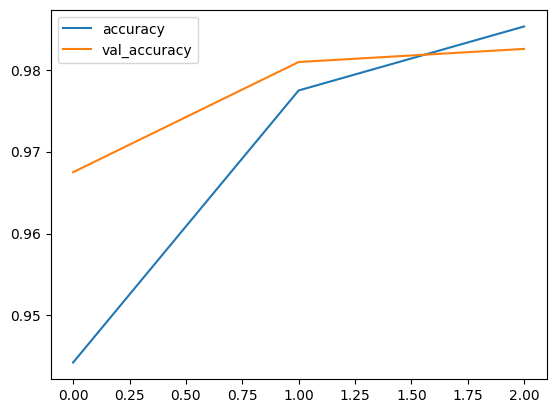

In [27]:
print("JANANI.V.S 212222230050")
metrics[['accuracy','val_accuracy']].plot()

JANANI.V.S 212222230050


<Axes: >

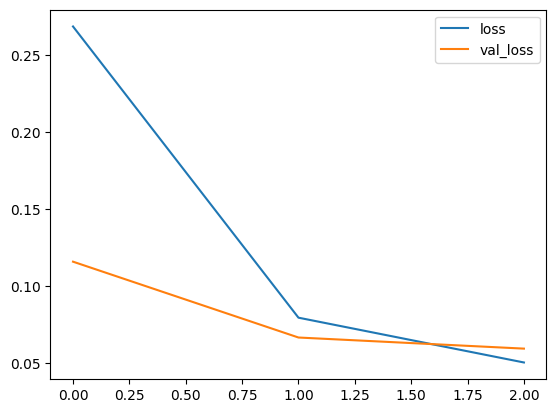

In [28]:
print("JANANI.V.S 212222230050")
metrics[['loss','val_loss']].plot()

In [30]:
i = 20
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("JANANI.V.S 212222230050")
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)

for w, true, pred in zip(X_test[i], y_true, p[0]):

    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 0s 35ms/step
JANANI.V.S 212222230050
Word           True 	 Pred

------------------------------
Authorities    O	O
in             O	O
Morocco        B-geo	B-geo
and            O	O
Turkey         B-geo	B-geo
have           O	O
arrested       O	O
two            O	O
men            O	O
blamed         O	O
for            O	O
unleashing     O	O
a              O	O
computer       O	O
worm           O	O
that           O	O
disrupted      O	O
networks       O	O
across         O	O
the            O	O
United         B-geo	B-geo
States         I-geo	I-geo
last           O	O
week           O	O
.              O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O